- In this notebook, I show the performance of ONet  
- As I mentioned in the first notebook (step 1), I will not show the repetitive parts. 

## The ONet Box
- Given the image, and the bounding boxes generated from the **rnet box**, it generates the image boxes with the size of 48

- Then, it puts these image boxes into RNet to get prediction boxes, converts the boxes into squares and calibrates them according to the offset values.

- After that, it chooses the boxes that might have face (larger than **MIN_FACE_SIZE**) based on the **THRESHOLDS** and deletes the repetitive boxes based on the **NMS_THRESHOLDS**  
- Finally, it returns the bounding box information to show the images.

In [2]:
THRESHOLDS = [0.85, 0.03, 0.3]
NMS_THRESHOLDS = [0.5, 0.9, 0.3]
MIN_FACE_SIZE = 15.0

def onet_boxes(img, onet, bounding_boxes, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS):
    onet.eval()
    img_boxes = get_image_boxes(bounding_boxes, img, size=48)
    img_boxes = torch.FloatTensor(img_boxes)
    img_boxes = img_boxes.cuda()
    if img_boxes.size(0)==0:
        return []
    output = onet(img_boxes)
    probs = output[0].data.cpu().numpy()
    offsets = output[1].data.cpu().numpy()

    keep = np.where(probs[:, 0] > thresholds[2])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 0].reshape((-1,))
    offsets = offsets[keep]

    keep = nms(bounding_boxes, nms_thresholds[2])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
    return bounding_boxes

## Show the Boxes

#### Set the parameters and Load Models

In [103]:
train_txt_path='../input/wider-data/WIDER/wider_face_train_bbx_gt.txt'
eval_txt_path='../input/wider-data/WIDER/wider_face_val_bbx_gt.txt'
train_img_path='../input/wider-data/WIDER/WIDER_train'
eval_img_path='../input/wider-data/WIDER/WIDER_val'
pnet_weight_path='../input/for-rnet/pnet_10000_40.pkl'
rnet_weight_path='../input/rnet-weights/rnet_12798_60_1.pkl'
onet_weight_path='../input/onet-weights/onet_12708_60_2.pkl'
train_num=None
eval_num=None
class_data_augment = 3 
pnet=P_Net().cuda()
pnet.load_state_dict(torch.load(pnet_weight_path))
pnet.eval()
rnet=R_Net().cuda()
rnet.load_state_dict(torch.load(rnet_weight_path))
rnet.eval()
onet=O_Net().cuda()
onet.load_state_dict(torch.load(onet_weight_path))
onet.eval()

O_Net(
  (pre_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): PReLU(num_parameters=1)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (10): PReLU(num_parameters=1)
  )
  (conv5): Linear(in_features=512, out_features=256, bias=True)
  (prelu5): PReLU(num_parameters=1)
  (conv6_1): Linear(in_features=256, out_features=1, bias=True)
  (conv6_2): Linear(in_features=256, out_features=4, bias=True)
  (conv6_3): Linear(in_features=256, out_features=10, bias=True)
)

#### Open the image and show the PNet performance

185


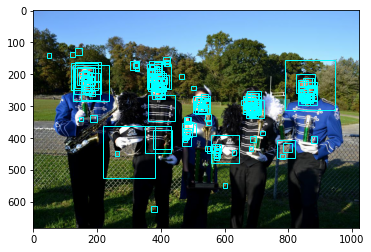

In [105]:
img = Image.open('../input/wider-data/WIDER/WIDER_train/0--Parade/0_Parade_marchingband_1_95.jpg')
bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
print(len(bounding_boxes))
show_boxes(img, bounding_boxes)

#### Show the RNet performance

24


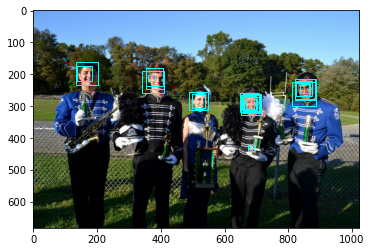

In [106]:
bounding_boxes=rnet_boxes(img, rnet, bounding_boxes, show_boxes=False)
print(len(bounding_boxes))
show_boxes(img, bounding_boxes)

#### Show the ONet performance

5


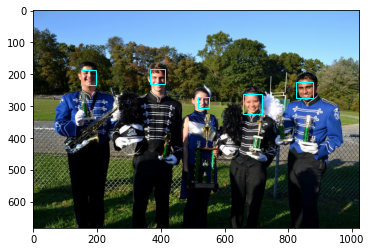

In [107]:
bounding_boxes=onet_boxes(img, onet, bounding_boxes)
print(len(bounding_boxes))
show_boxes(img, bounding_boxes)

#### Show more sample images from the training set

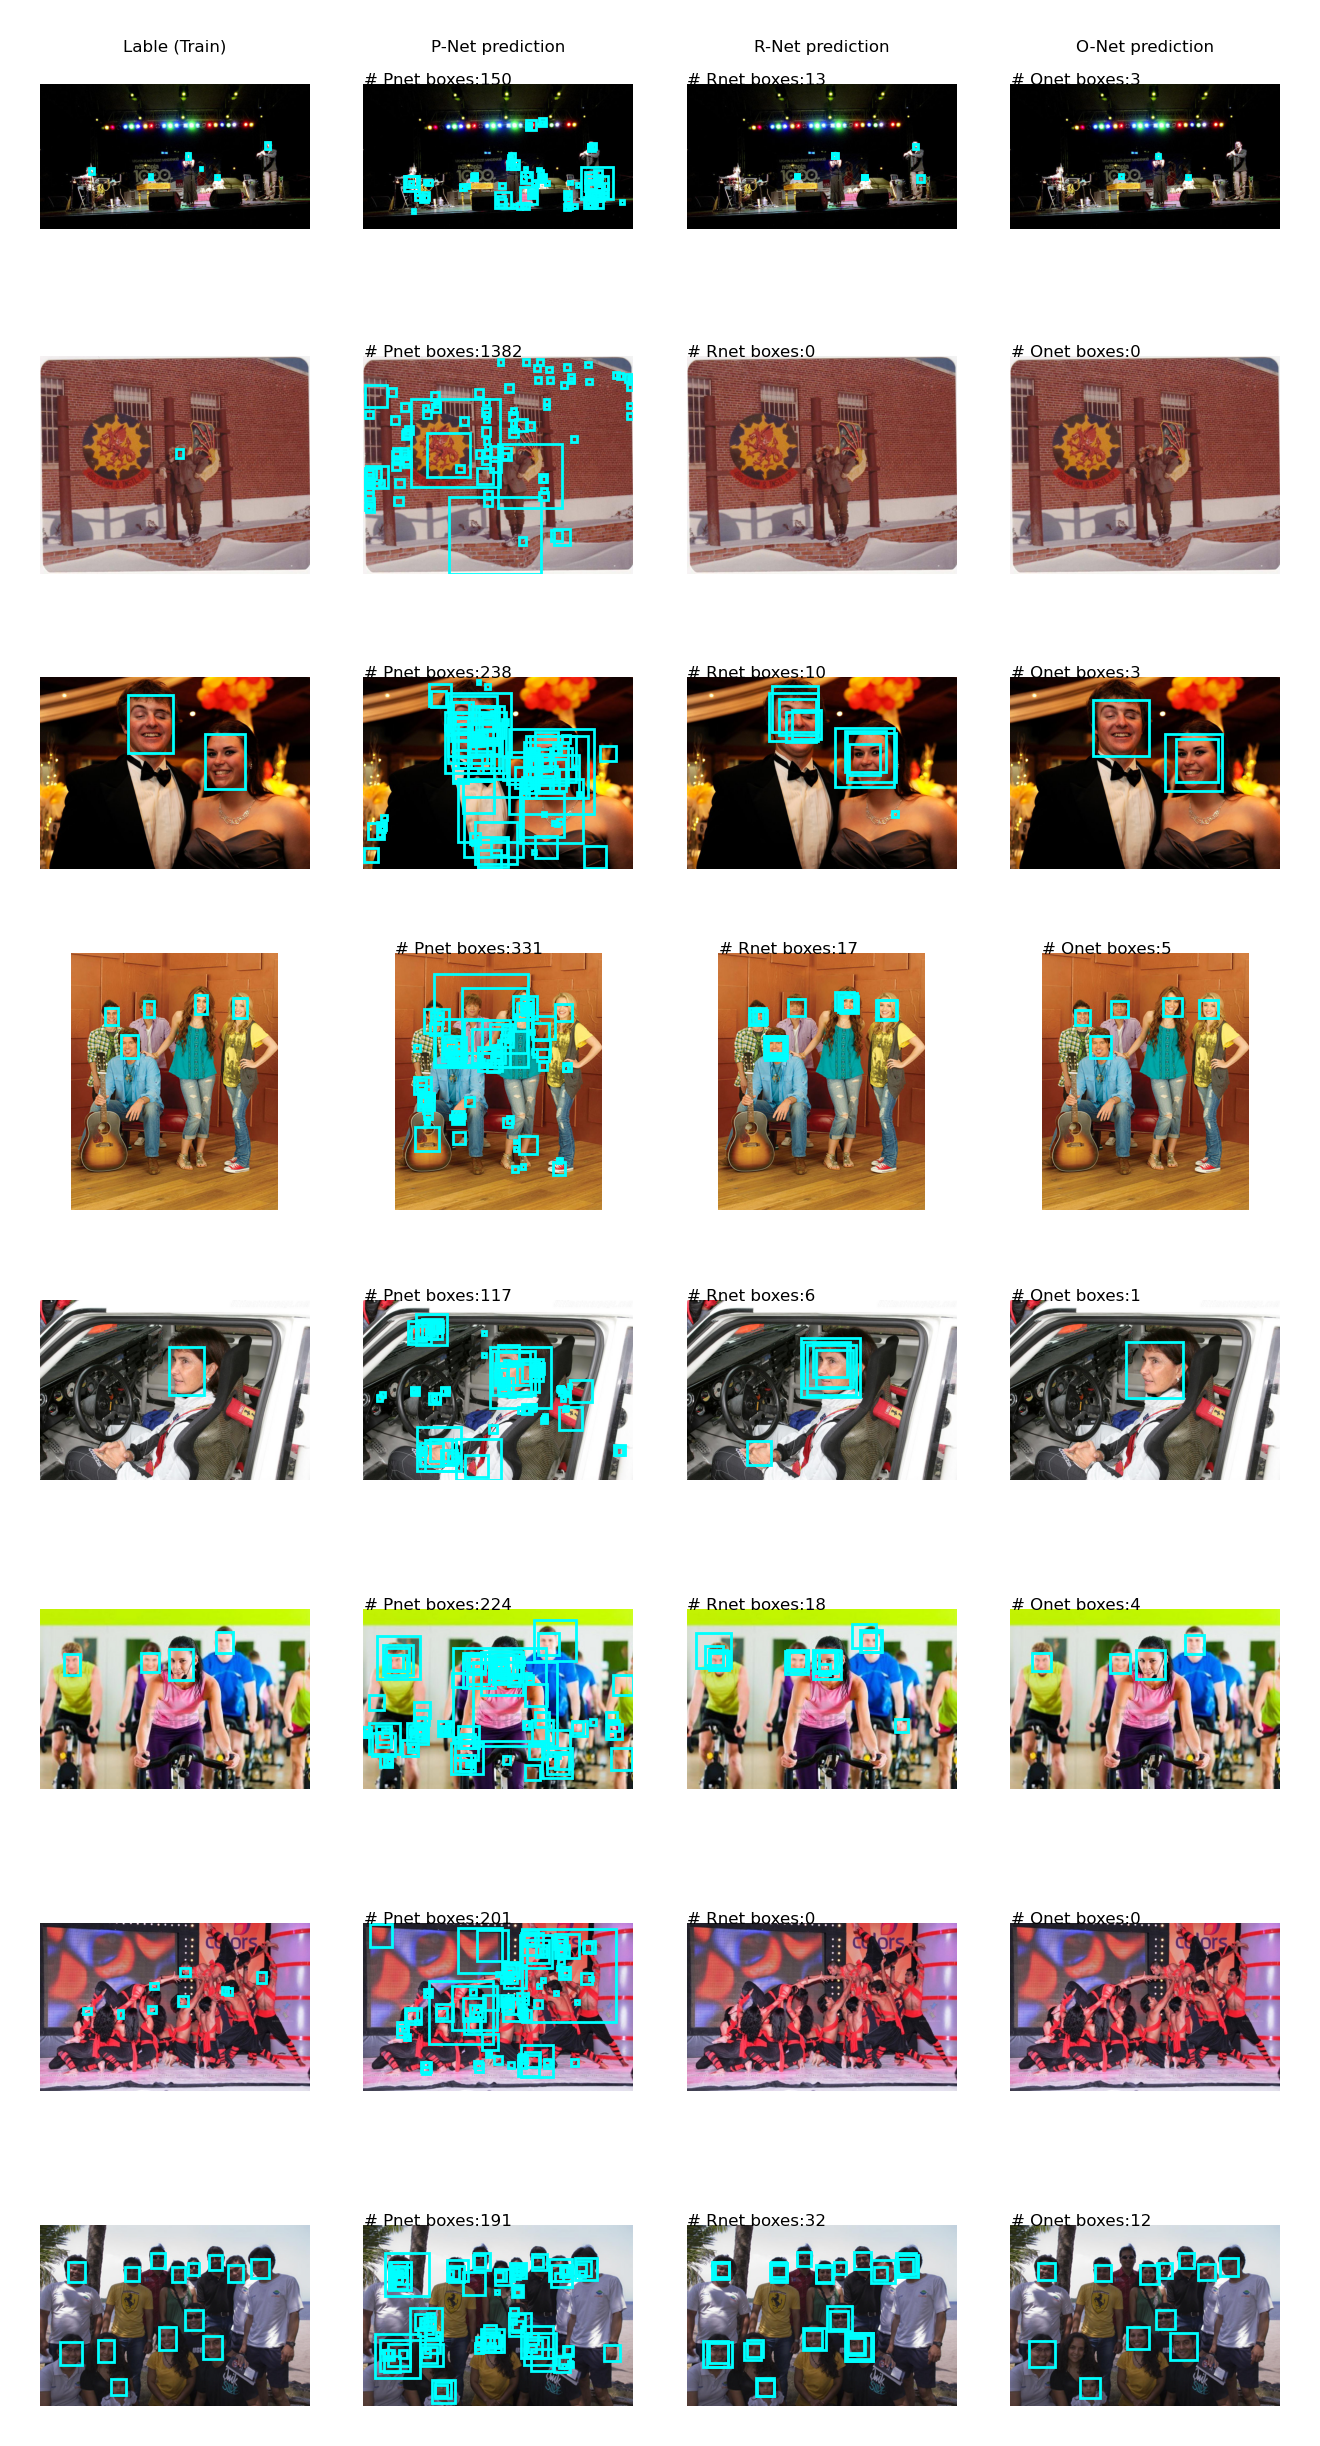

In [124]:
# get 8 fixed images
data_for_demo = create_pnet_data_txt_parser(train_txt_path,train_img_path ,num_data=1090)
data_for_demo=data_for_demo[-8:]


# demo and plot
fig, ax = plt.subplots(8,4,dpi = 400, figsize=(4,8))

for i in range(len(data_for_demo)):
    img_pth, gts = data_for_demo[i]
    img = Image.open(img_pth)
    p_bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    r_bounding_boxes=rnet_boxes(img, rnet, p_bounding_boxes, show_boxes=False)
    o_bounding_boxes=onet_boxes(img, onet, r_bounding_boxes)
    ax[i,0].imshow(img)
    for b in gts:
        ax[i,0].add_patch(plt.Rectangle((b[0], b[1]), b[2], b[3], fill=False, edgecolor = 'cyan',linewidth=0.5));
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# Pnet boxes:'+str(len(p_bounding_boxes)),fontsize=3)
    for b in p_bounding_boxes[:100]:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
    
    ax[i,2].imshow(img)
    ax[i,2].text(0, 0, '# Rnet boxes:'+str(len(r_bounding_boxes)),fontsize=3)
    for b in r_bounding_boxes:
        ax[i,2].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
        
    ax[i,3].imshow(img)
    ax[i,3].text(0, 0, '# Onet boxes:'+str(len(o_bounding_boxes)),fontsize=3)
    for b in o_bounding_boxes:
        ax[i,3].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   


for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Lable (Train)",fontsize=3)
ax[0][1].set_title("P-Net prediction",fontsize=3)
ax[0][2].set_title("R-Net prediction",fontsize=3)
ax[0][3].set_title("O-Net prediction",fontsize=3)
fig.show()
fig.savefig('demo_train.png')

#### Show more sample images from the eval set

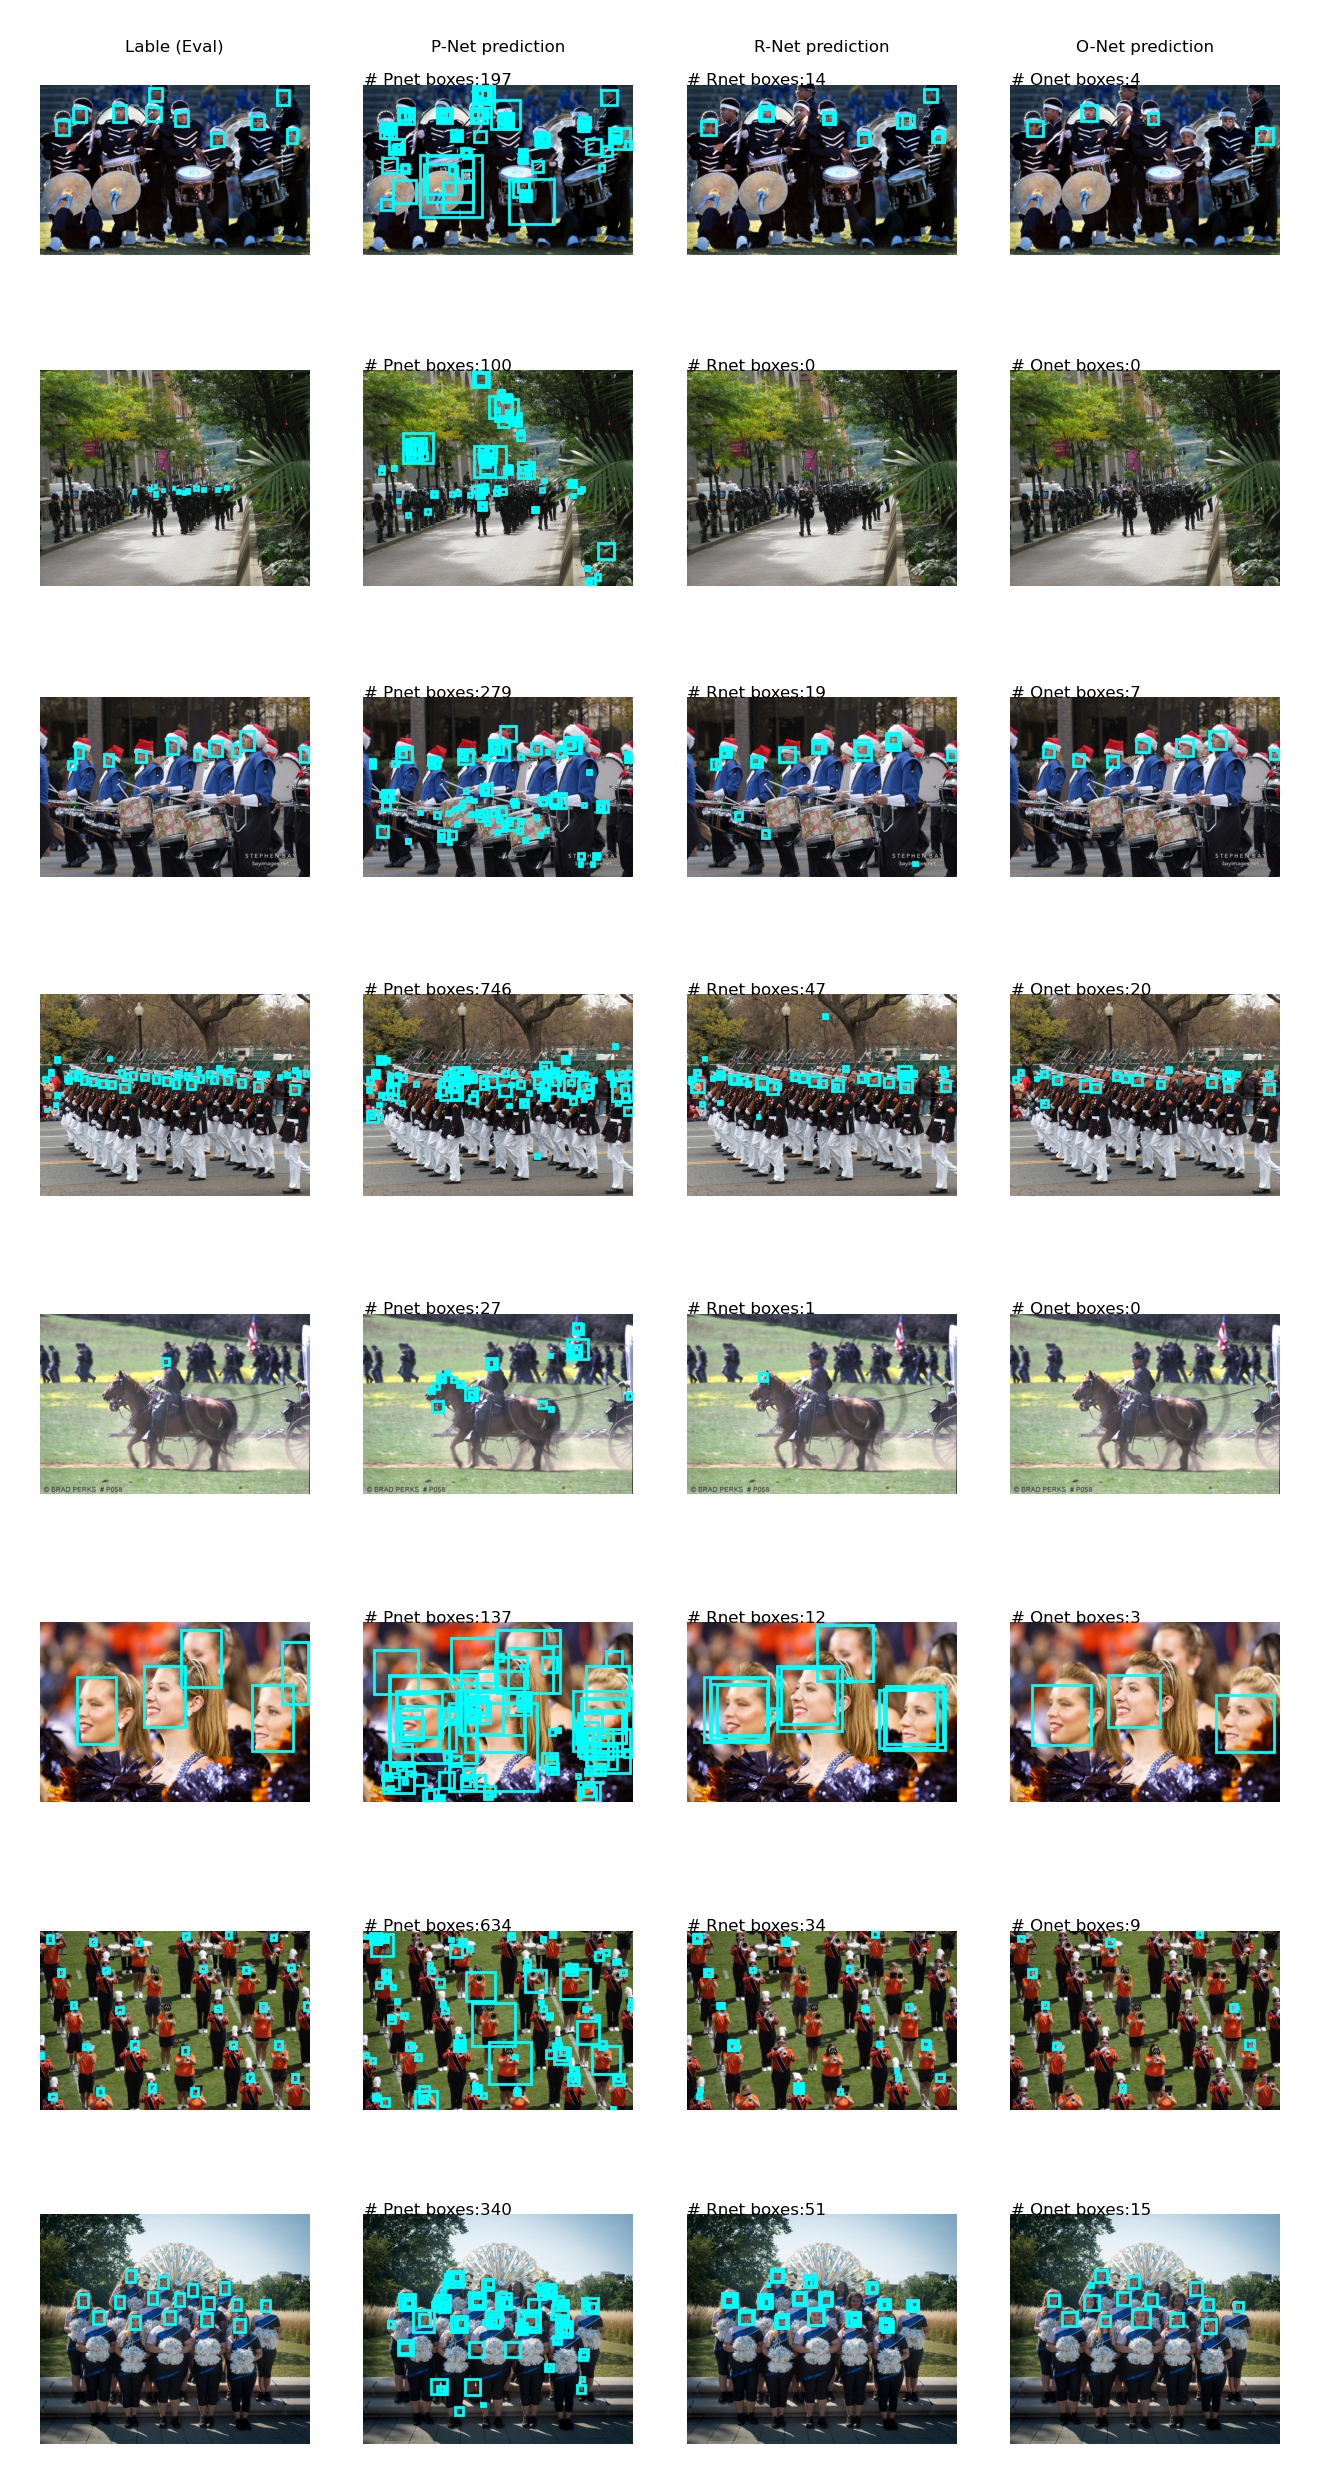

In [121]:
# get 8 fixed images
data_for_demo = create_pnet_data_txt_parser(eval_txt_path,eval_img_path ,num_data=190)
data_for_demo=data_for_demo[-8:]

# demo and plot
fig, ax = plt.subplots(8,4,dpi = 400, figsize=(4,8))

for i in range(len(data_for_demo)):
    img_pth, gts = data_for_demo[i]
    img = Image.open(img_pth)
    p_bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    r_bounding_boxes=rnet_boxes(img, rnet, p_bounding_boxes, show_boxes=False)
    o_bounding_boxes=onet_boxes(img, onet, r_bounding_boxes)
    ax[i,0].imshow(img)
    for b in gts:
        ax[i,0].add_patch(plt.Rectangle((b[0], b[1]), b[2], b[3], fill=False, edgecolor = 'cyan',linewidth=0.5));
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# Pnet boxes:'+str(len(p_bounding_boxes)),fontsize=3)
    for b in p_bounding_boxes[:100]:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
    
    ax[i,2].imshow(img)
    ax[i,2].text(0, 0, '# Rnet boxes:'+str(len(r_bounding_boxes)),fontsize=3)
    for b in r_bounding_boxes:
        ax[i,2].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
        
    ax[i,3].imshow(img)
    ax[i,3].text(0, 0, '# Onet boxes:'+str(len(o_bounding_boxes)),fontsize=3)
    for b in o_bounding_boxes:
        ax[i,3].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   


for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Lable (Eval)",fontsize=3)
ax[0][1].set_title("P-Net prediction",fontsize=3)
ax[0][2].set_title("R-Net prediction",fontsize=3)
ax[0][3].set_title("O-Net prediction",fontsize=3)
fig.show()
fig.savefig('demo_eval.png')